# üß™ Exp√©rimentations - Apprentissage par renforcement
Dans ce notebook, nous comparons plusieurs algorithmes (Monte Carlo, Q-Learning, Expected SARSA, Dyna-Q, Dyna-Q+)
sur des environnements comme Monty Hall Level 1.

## Imports

In [1]:
import argparse
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

# === Environnements ===
from reinfolearn.environment.grid_world import GridWorldMDP
from reinfolearn.environment.line_world import LineWorldMDP
from reinfolearn.environment.montyhall_level1 import MontyHallLevel1MDP
from reinfolearn.environment.montyhall_level2 import MontyHallLevel2MDP
from reinfolearn.environment.rock_paper_scissors import RockPaperScissorsMDP
from reinfolearn.environment.rock_paper_scissors_two_rounds import TwoRoundRPS



# === Algorithmes ===
from reinfolearn.algorithm.dp.policy_iteration import policy_iteration
from reinfolearn.algorithm.dp.value_iteration import value_iteration
from reinfolearn.algorithm.mc.mc_on_policy import mc_on_policy_first_visit
from reinfolearn.algorithm.mc.mc_off_policy import mc_off_policy_control
from reinfolearn.algorithm.mc.mc_exploring_starts import mc_exploring_starts
from reinfolearn.algorithm.td.q_learning import q_learning
from reinfolearn.algorithm.td.sarsa import sarsa
from reinfolearn.algorithm.td.expected_sarsa import expected_sarsa
from reinfolearn.algorithm.pn.dyna_q import dyna_q
from reinfolearn.algorithm.pn.dyna_q_plus import dyna_q_plus

# === Utilitaires ===
from reinfolearn.utils.io_utils import save_policy, save_q_table, save_values, save_scores
from reinfolearn.utils.plot_utils import plot_scores, plot_convergence 
from reinfolearn.utils.metrics_utils import evaluate_policy_score, summarize_policy_scores

## Fonction standard d'exp√©rimentation

In [2]:
def get_env(env_name):
    envs = {
        "grid": GridWorldMDP(),
        "line": LineWorldMDP(),
        "monty": MontyHallLevel1MDP(),
        "monty_level2": MontyHallLevel2MDP(),
        "rps": RockPaperScissorsMDP(),
        "rps_two_rounds": TwoRoundRPS()
    }
    return envs[env_name]

In [3]:
def run_experiment(env_class, algo_fn, algo_name, env_name, **kwargs):
    env = env_class()

    # create output directory if it doesn't exist
    output_dir = f"outputs/{env_name}/{algo_name}"
    os.makedirs(output_dir, exist_ok=True)

    if algo_name == "policy_iteration":
        policy, V, mean_value_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for policy iteration
        save_scores(mean_value_history, f"{output_dir}/value_convergence.npy")

        print(f"Politique et valeurs sauvegard√©es pour {env_name} avec {algo_name}")
        return policy, V, mean_value_history
    
    elif algo_name == "value_iteration":
        policy, V, delta_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for value iteration
        save_scores(delta_history, f"{output_dir}/delta_convergence.npy")

        print(f"Politique et valeurs sauvegard√©es pour {env_name} avec {algo_name}")
        return policy, V, delta_history
    else:
        policy, Q, scores = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_q_table(Q, f"{output_dir}/q_table.pkl") # Save Q-table for TD methods
        save_scores(scores, f"{output_dir}/episode_scores.npy")
    return policy, Q, scores

## Exp√©rimentation

Dans cette section, nous allons ex√©cuter les algorithmes sur diff√©rents environnements et collecter les scores. 

### √âtude sur l'environnement line

In [4]:
env_name = "line"
env_class = LineWorldMDP

# Policy Iteration
policy_pi, V_pi, _ = run_experiment(
    env_class, policy_iteration, "policy_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=10)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)

# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(env_class, value_iteration, "value_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=10)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

# Pour Monte Carlo Off-Policy Control
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
    env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
   nb_episodes=10, gamma=0.99)


# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)



Policy Iteration:   0%|          | 1/1000 [00:00<00:02, 492.87it/s]


Politique et valeurs sauvegard√©es pour line avec policy_iteration


√âvaluation de la politique: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 889.89it/s]


Policy Iteration summary: {'mean': np.float64(1.0), 'std': np.float64(0.0), 'min': np.float64(1.0), 'max': np.float64(1.0)}
Politique et valeurs sauvegard√©es pour line avec value_iteration


√âvaluation de la politique: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 30795.18it/s]


Value Iteration summary: {'mean': np.float64(1.0), 'std': np.float64(0.0), 'min': np.float64(1.0), 'max': np.float64(1.0)}


Dyna-Q+: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 703.79it/s]


#### Comparaison graphique des performances

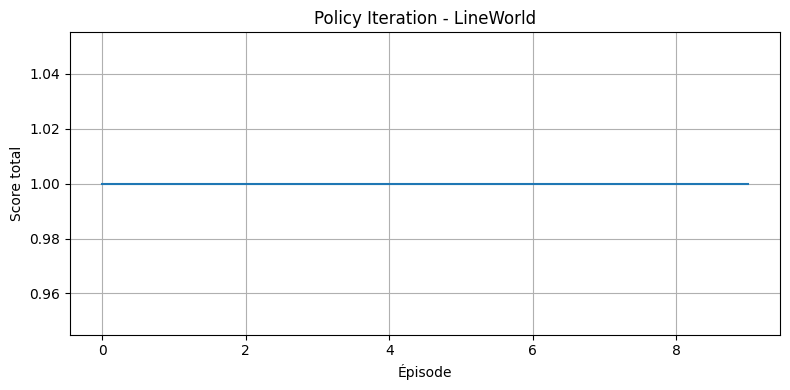

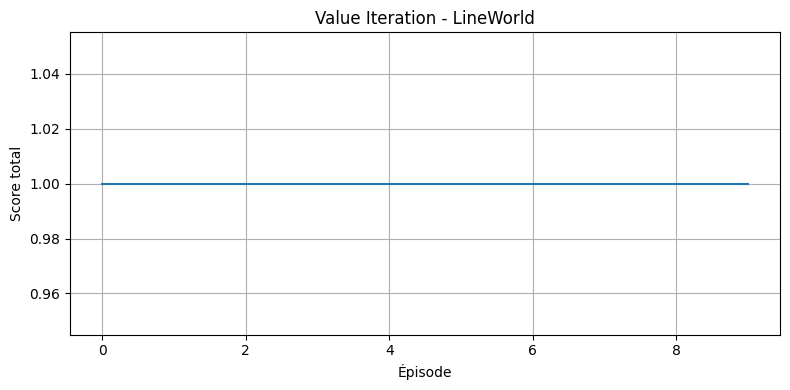

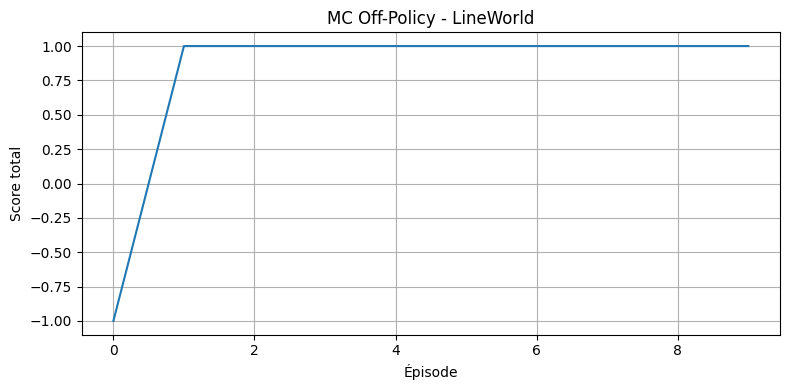

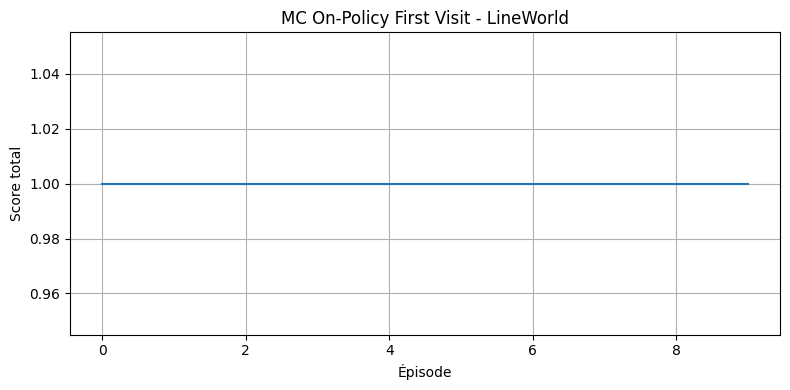

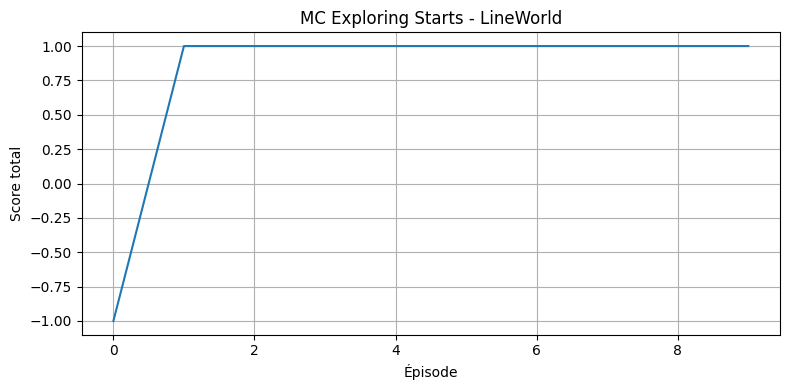

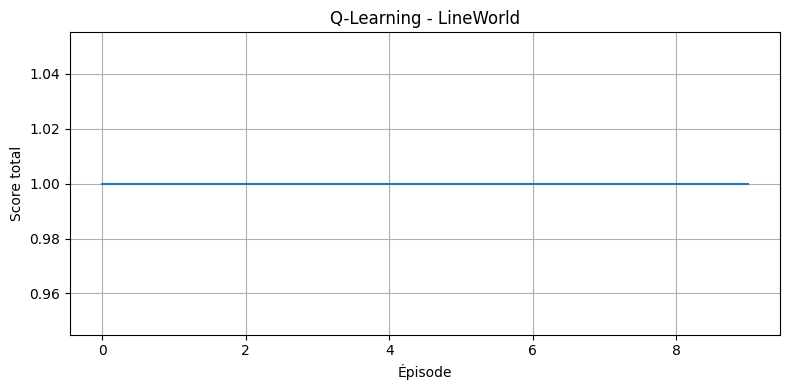

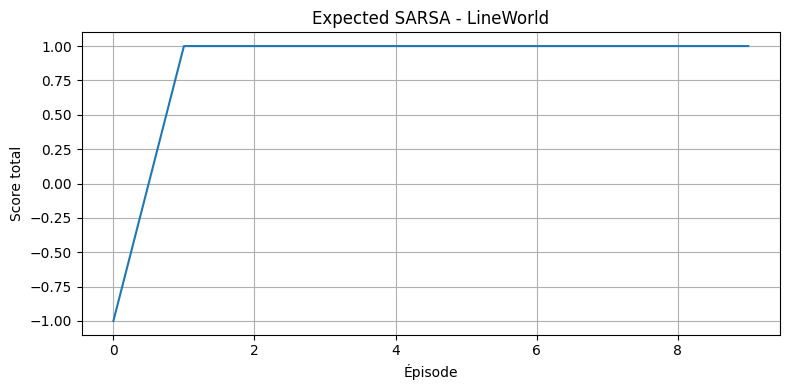

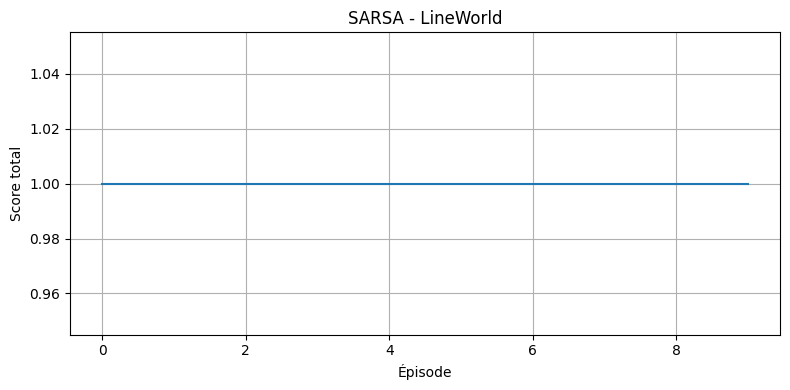

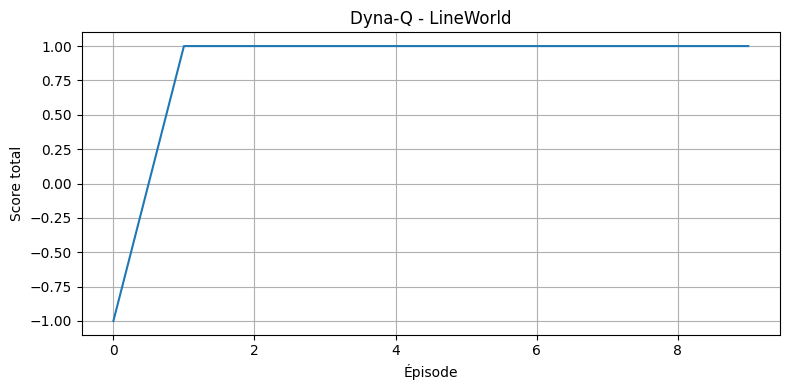

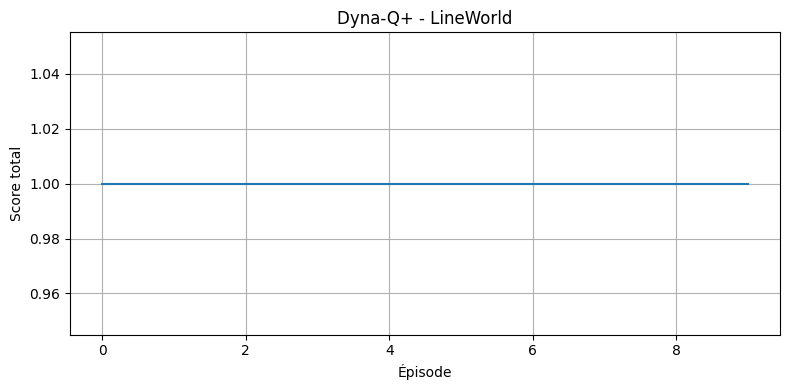

In [5]:
plot_scores(scores_pi, title="Policy Iteration - LineWorld")
plot_scores(scores_vi, title="Value Iteration - LineWorld")
plot_scores(scores_mc_off_policy, title="MC Off-Policy - LineWorld")
plot_scores(scores_mc_on_policy, title="MC On-Policy First Visit - LineWorld")
plot_scores(scores_mc_exploring_starts, title="MC Exploring Starts - LineWorld")
plot_scores(scores_q, title="Q-Learning - LineWorld")
plot_scores(scores_esarsa, title="Expected SARSA - LineWorld")
plot_scores(scores_sarsa, title="SARSA - LineWorld")
plot_scores(scores_dq, title="Dyna-Q - LineWorld")
plot_scores(scores_dqplus, title="Dyna-Q+ - LineWorld")


#### Interpretation  **line world** : 

L‚Äôenvironnement LineWorld √©tant extr√™mement simple, avec une dynamique totalement d√©terministe et une structure lin√©aire tr√®s restreinte, tous les algorithmes convergent tr√®s rapidement vers la solution optimale. Les m√©thodes de Dynamic Programming (Value Iteration, Policy Iteration) trouvent imm√©diatement la politique optimale puisqu‚Äôelles exploitent directement le mod√®le connu des transitions. Les algorithmes Monte Carlo atteignent √©galement le score optimal, mais n√©cessitent au moins un ou deux √©pisodes pour converger, le temps d‚Äô√©chantillonner les r√©sultats possibles. Quant aux approches bas√©es sur le Temporal Difference Learning (Sarsa, Expected Sarsa, Q-Learning), elles convergent sans difficult√©, bien que leur capacit√© d‚Äôexploration et d‚Äôadaptation soit sous-exploit√©e ici du fait de la faible complexit√© de l‚Äôenvironnement. Enfin, les m√©thodes de Planning comme Dyna-Q n‚Äôapportent aucun b√©n√©fice particulier dans ce contexte, car l‚Äôenvironnement ne n√©cessite pas de mod√©lisation pour √™tre r√©solu efficacement. Globalement, ces r√©sultats confirment que les algorithmes les plus adapt√©s √† LineWorld sont ceux qui exploitent directement un mod√®le connu, comme DP ou Value Iteration, l√† o√π les m√©thodes d‚Äôexploration sont ici superflues.

### √âtude sur l'environnement grid

In [6]:
env_name = "grid"
env_class = GridWorldMDP

# Policy Iteration
policy_pi, V_pi, _ = run_experiment(
    env_class, policy_iteration, "policy_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)

scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=10)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)

# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(env_class, value_iteration, "value_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=10)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

# Pour Monte Carlo Off-Policy Control
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
    env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
   nb_episodes=10, gamma=0.99)


# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=10, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)


Policy Iteration:   1%|          | 7/1000 [00:00<00:35, 27.87it/s]


Politique et valeurs sauvegard√©es pour grid avec policy_iteration


√âvaluation de la politique: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 26990.37it/s]


Policy Iteration summary: {'mean': np.float64(1.0), 'std': np.float64(0.0), 'min': np.float64(1.0), 'max': np.float64(1.0)}
Politique et valeurs sauvegard√©es pour grid avec value_iteration


√âvaluation de la politique: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 46916.15it/s]


Value Iteration summary: {'mean': np.float64(1.0), 'std': np.float64(0.0), 'min': np.float64(1.0), 'max': np.float64(1.0)}


Dyna-Q+: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:09<00:00,  1.03it/s]


#### Comparaison graphique des performances

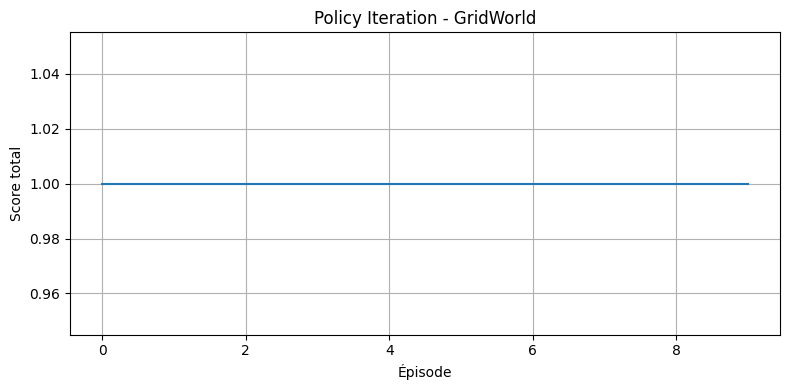

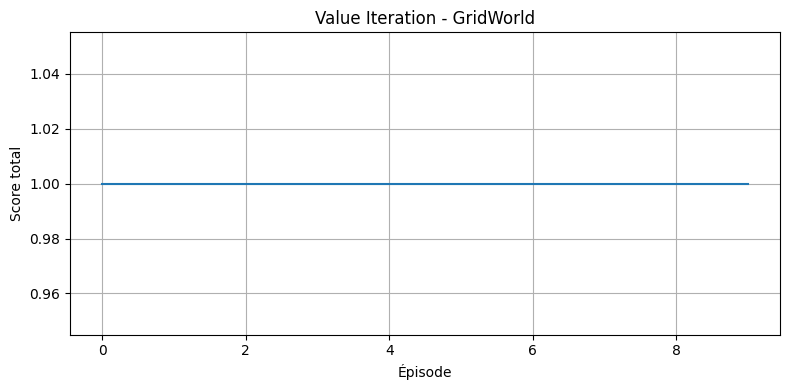

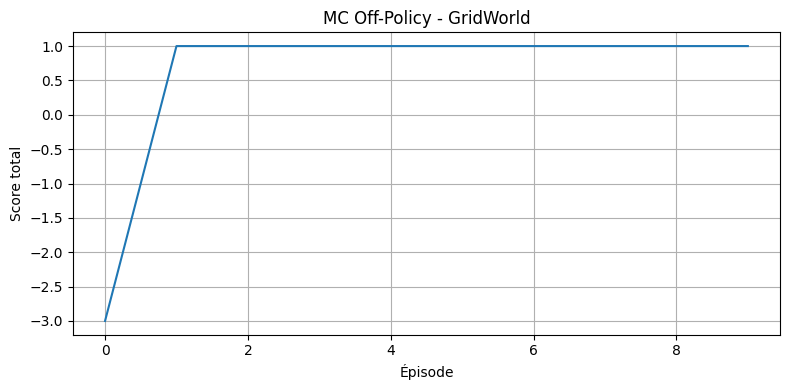

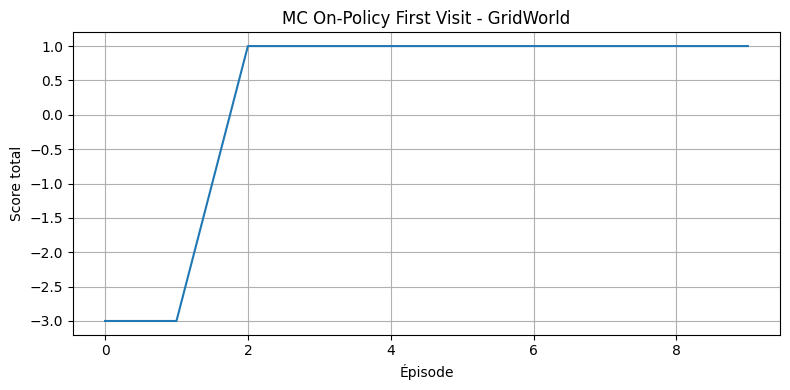

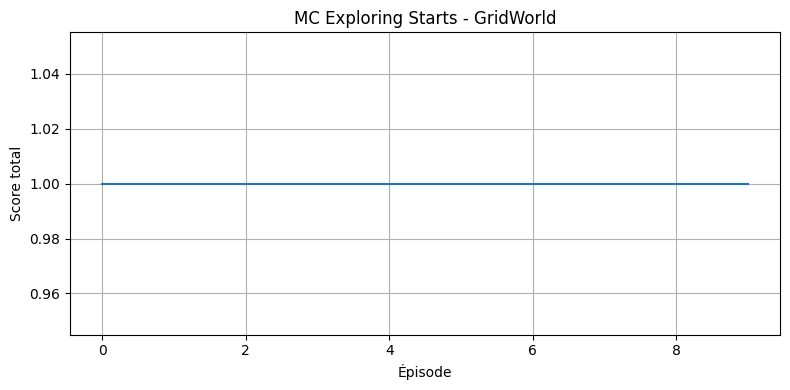

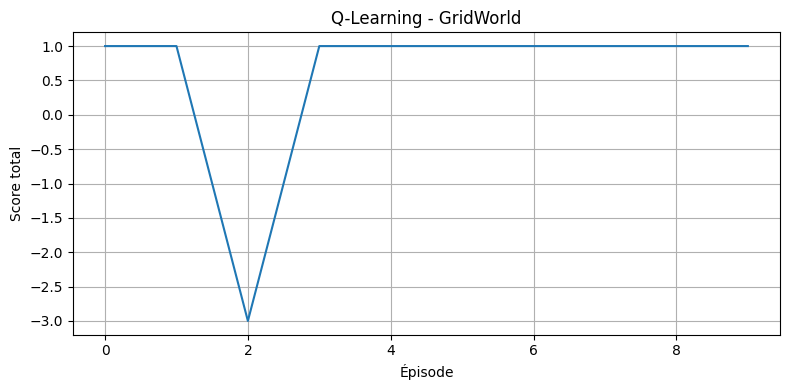

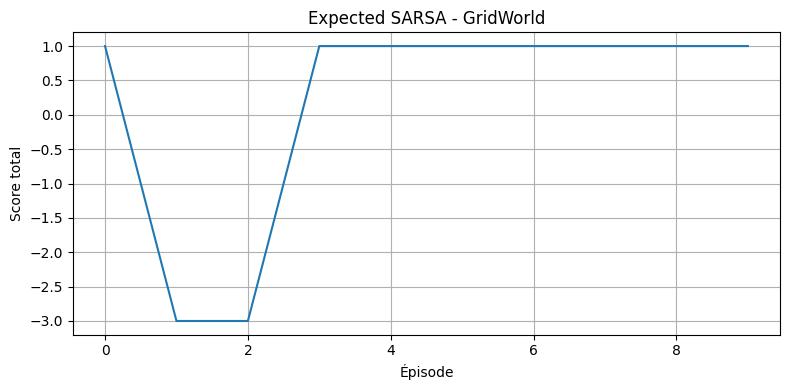

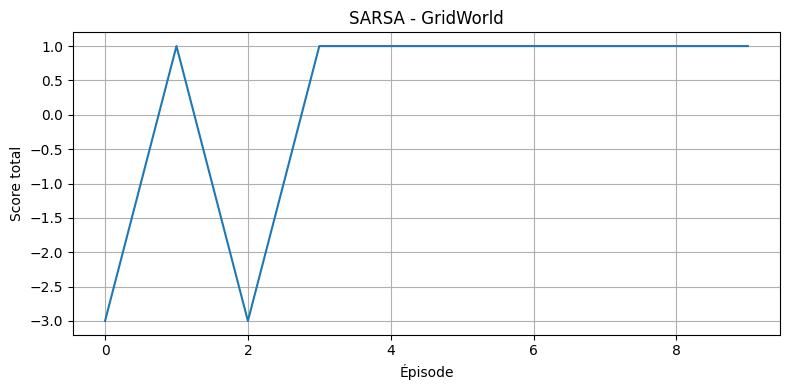

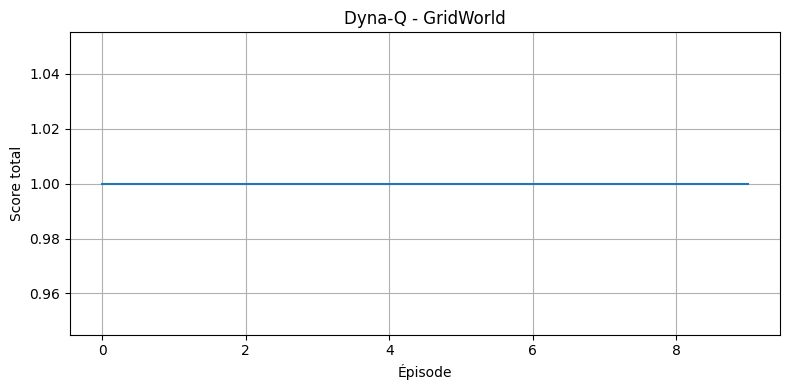

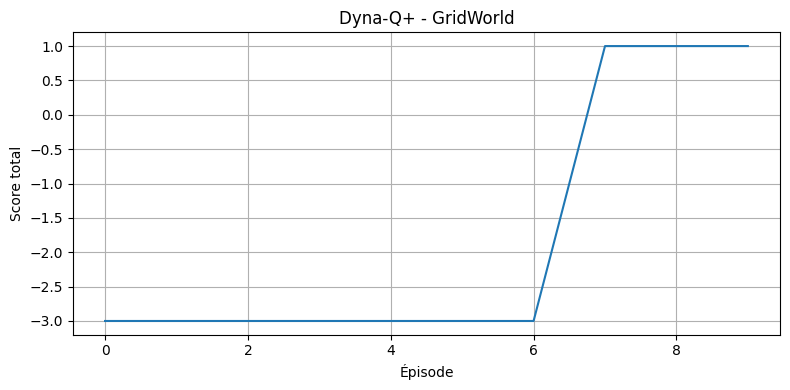

In [7]:
plot_scores(scores_pi, title="Policy Iteration - GridWorld")
plot_scores(scores_vi, title="Value Iteration - GridWorld")
plot_scores(scores_mc_off_policy, title="MC Off-Policy - GridWorld")
plot_scores(scores_mc_on_policy, title="MC On-Policy First Visit - GridWorld")
plot_scores(scores_mc_exploring_starts, title="MC Exploring Starts - GridWorld")
plot_scores(scores_q, title="Q-Learning - GridWorld")
plot_scores(scores_esarsa, title="Expected SARSA - GridWorld")
plot_scores(scores_sarsa, title="SARSA - GridWorld")
plot_scores(scores_dq, title="Dyna-Q - GridWorld")
plot_scores(scores_dqplus, title="Dyna-Q+ - GridWorld")


#### Interpretation grid world : 
L‚Äôenvironnement GridWorld est l√©g√®rement plus complexe que LineWorld mais reste simple, enti√®rement d√©terministe et connu de l‚Äôagent. Les algorithmes de Dynamic Programming, tels que Policy Iteration et Value Iteration, convergent imm√©diatement vers la politique optimale sans n√©cessiter d‚Äôexploration empirique, ce qui se refl√®te par un score constant d√®s le d√©part. √Ä l‚Äôinverse, les m√©thodes Monte Carlo (On-Policy, Off-Policy, Exploring Starts) montrent une l√©g√®re phase d‚Äôadaptation au d√©but, n√©cessitant de vivre quelques √©pisodes pour comprendre la dynamique et corriger la politique. Une fois l‚Äôenvironnement explor√©, ces m√©thodes parviennent elles aussi √† maximiser le score. Pour les algorithmes de TD Learning (Q-Learning, Sarsa, Expected Sarsa), on observe des oscillations en d√©but d‚Äôapprentissage dues √† leur n√©cessit√© d‚Äôexplorer activement l‚Äôenvironnement et d‚Äôajuster leur politique progressivement. Toutefois, apr√®s quelques √©pisodes, ils convergent √©galement vers le comportement optimal attendu. Enfin, les m√©thodes de Planning (Dyna-Q, Dyna-Q+) sont ici peu pertinentes dans un environnement aussi simple et connu, mais elles permettent d‚Äôatteindre un r√©sultat satisfaisant. On remarque n√©anmoins un l√©ger d√©calage dans l‚Äôadaptation de Dyna-Q+, qui met plus de temps √† converger que Dyna-Q, ce qui s‚Äôexplique par son m√©canisme favorisant l‚Äôexploration de transitions rares

### √âtude sur l'environnement MontyHallLevel1MDP

In [8]:
env_name = "monty"
env_class = MontyHallLevel1MDP

def run_experiment(env_class, algo_fn, algo_name, env_name, **kwargs):
    env = env_class()

    # create output directory if it doesn't exist
    output_dir = f"outputs/{env_name}/{algo_name}"
    os.makedirs(output_dir, exist_ok=True)

    if algo_name == "policy_iteration":
        policy, V, mean_value_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for policy iteration
        save_scores(mean_value_history, f"{output_dir}/value_convergence.npy")

        print(f"Politique et valeurs sauvegard√©es pour {env_name} avec {algo_name}")
        return policy, V, mean_value_history
    
    elif algo_name == "value_iteration":
        policy, V, delta_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for value iteration
        save_scores(delta_history, f"{output_dir}/delta_convergence.npy")

        print(f"Politique et valeurs sauvegard√©es pour {env_name} avec {algo_name}")
        return policy, V, delta_history
    else:
        policy, Q, scores = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_q_table(Q, f"{output_dir}/q_table.pkl") # Save Q-table for TD methods
        save_scores(scores, f"{output_dir}/episode_scores.npy")
    return policy, Q, scores

#### Comparaison graphique des performances

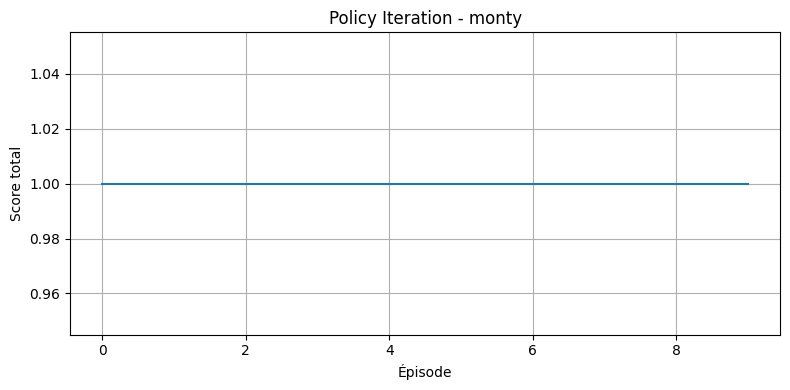

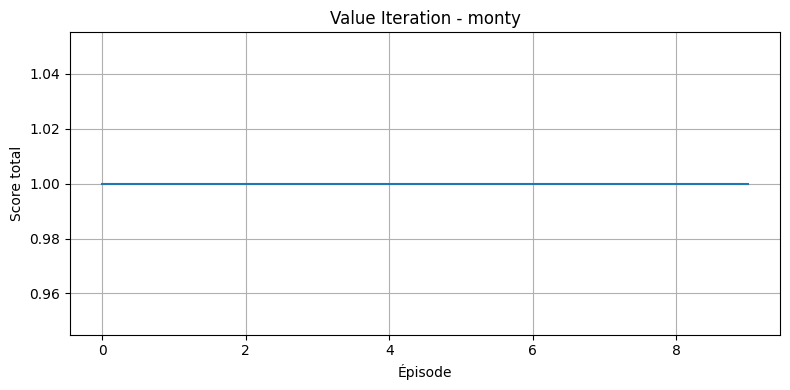

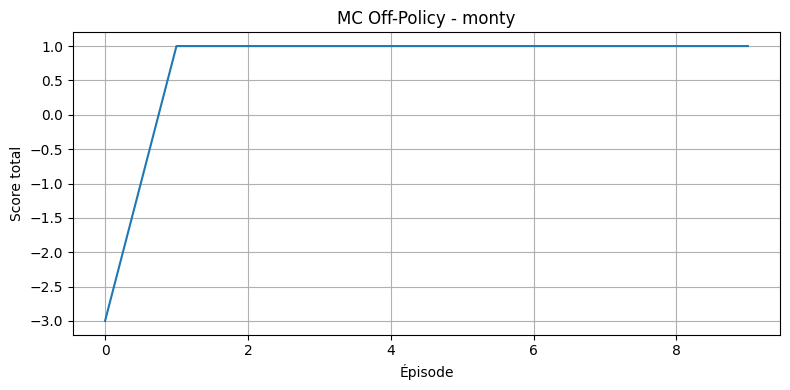

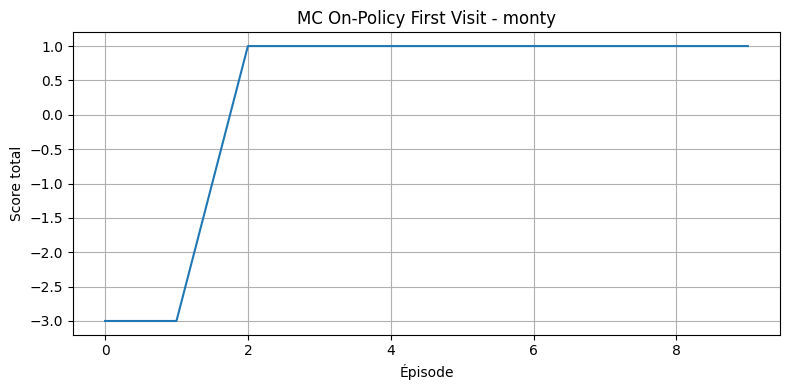

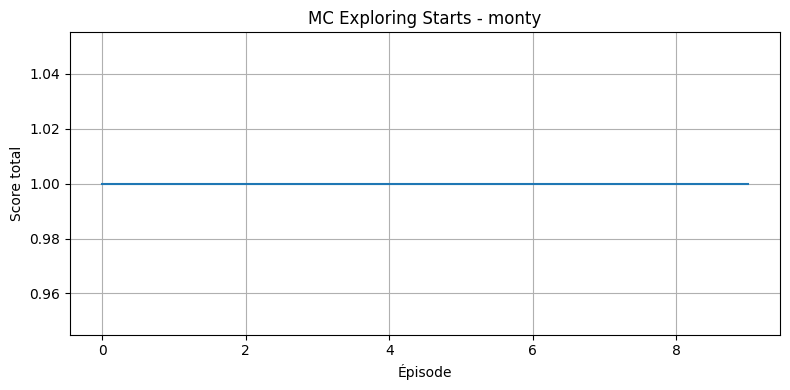

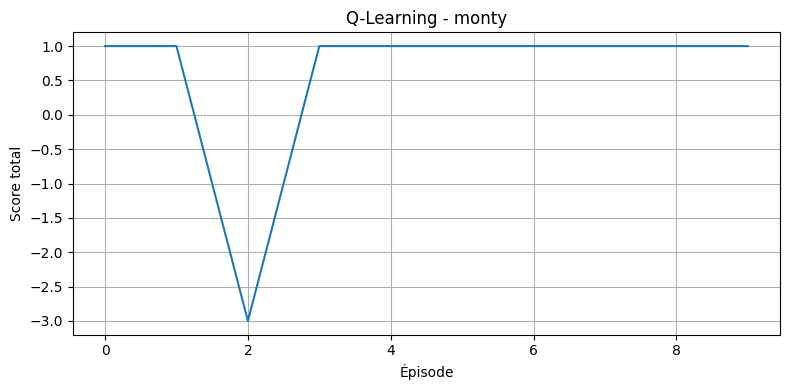

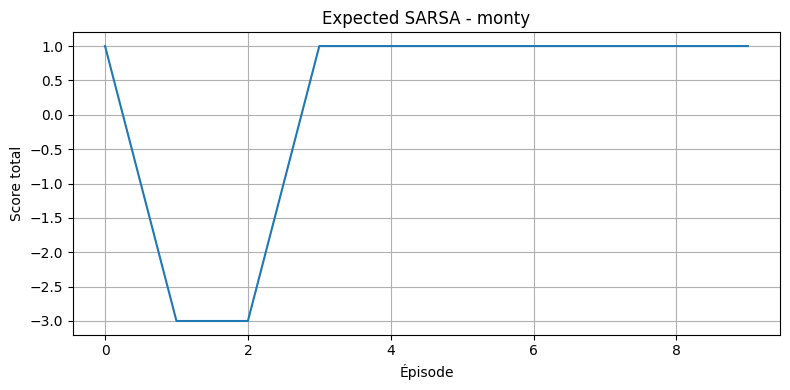

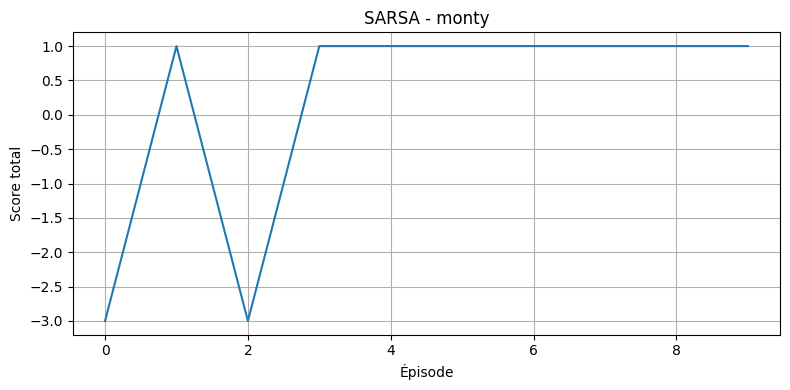

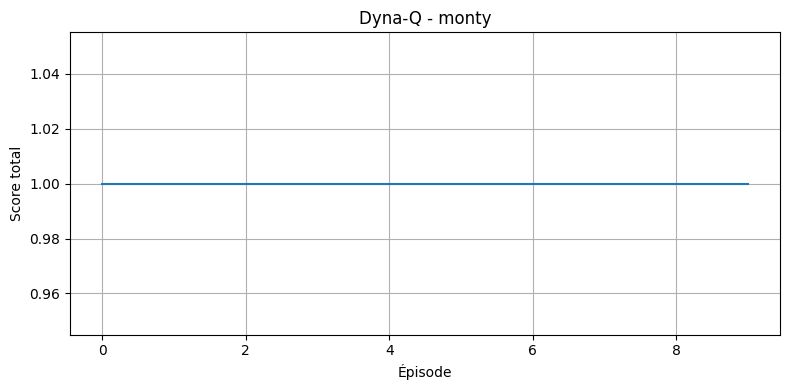

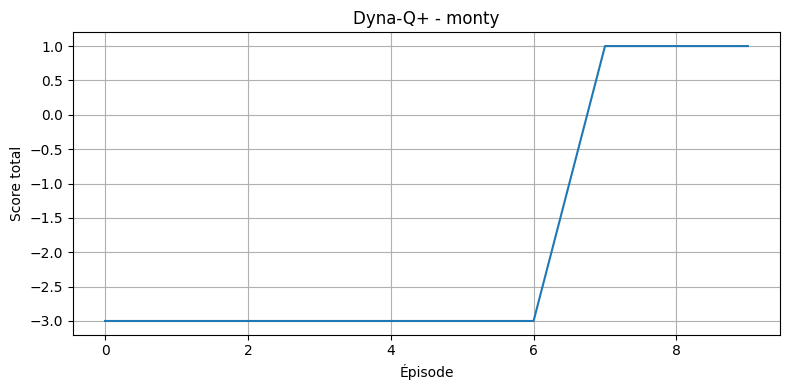

In [9]:
plot_scores(scores_pi, title=f"Policy Iteration - {env_name}")
plot_scores(scores_vi, title=f"Value Iteration - {env_name}")
plot_scores(scores_mc_off_policy, title=f"MC Off-Policy - {env_name}")
plot_scores(scores_mc_on_policy, title=f"MC On-Policy First Visit - {env_name}")
plot_scores(scores_mc_exploring_starts, title=f"MC Exploring Starts - {env_name}")
plot_scores(scores_q, title=f"Q-Learning - {env_name}")
plot_scores(scores_esarsa, title=f"Expected SARSA - {env_name}")
plot_scores(scores_sarsa, title=f"SARSA - {env_name}")
plot_scores(scores_dq, title=f"Dyna-Q - {env_name}")
plot_scores(scores_dqplus, title=f"Dyna-Q+ - {env_name}")

#### Interpretation 	Monty Hall "Paradox" - Niveau 1 :
 L‚Äôenvironnement Monty Hall niveau 1 √©tant extr√™mement simple et bien connu dans la litt√©rature, il est facilement r√©solu par les algorithmes de Dynamic Programming, notamment Policy Iteration et Value Iteration. Comme attendu, ces m√©thodes identifient imm√©diatement la politique optimale consistant √† syst√©matiquement changer de porte lors du second choix, ce qui explique la stabilit√© et la constance du score observ√© d√®s le d√©part. Les m√©thodes Monte Carlo (On-Policy, Off-Policy) permettent elles aussi d‚Äôatteindre la politique optimale, en exploitant l‚Äô√©chantillonnage des √©pisodes pour constater l‚Äôavantage de changer. Bien que leurs premiers √©pisodes puissent montrer des fluctuations, la convergence est tr√®s rapide. Les algorithmes de Temporal Difference Learning (Q-Learning, Sarsa, Expected Sarsa) convergent √©galement vers la bonne politique. Cependant, ils n√©cessitent quelques explorations et √©pisodes pour bien stabiliser l‚Äôapprentissage, ce qui se refl√®te dans leurs premi√®res oscillations avant convergence. Enfin, les m√©thodes de Planning telles que Dyna-Q ou Dyna-Q+ sont peu adapt√©es ici, car l‚Äôenvironnement est d√©j√† simple, totalement connu et n‚Äôexige aucune construction de mod√®le pour atteindre la solution optimale. Les performances observ√©es ne montrent d‚Äôailleurs aucun b√©n√©fice particulier li√© √† ces techniques

### √âtude sur l'environnement MontyHallLevel2MDP

In [12]:
env_name = "monty_level2"
env_class = MontyHallLevel2MDP 



# Policy Iteration
policy_pi, V_pi, _ = run_experiment(
    env_class, policy_iteration, "policy_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=10)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)

# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(env_class, value_iteration, "value_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=10)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

# Pour Monte Carlo Off-Policy Control 
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99
)

# Pour Monte Carlo Off-Policy Control
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
    env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
   nb_episodes=10, gamma=0.99)


# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99)

Policy Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]


Politique et valeurs sauvegard√©es pour monty_level2 avec policy_iteration


√âvaluation de la politique: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 6055.88it/s]


Policy Iteration summary: {'mean': np.float64(0.3), 'std': np.float64(0.45825756949558394), 'min': np.float64(0.0), 'max': np.float64(1.0)}
Politique et valeurs sauvegard√©es pour monty_level2 avec value_iteration


√âvaluation de la politique: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 5389.06it/s]


Value Iteration summary: {'mean': np.float64(0.2), 'std': np.float64(0.4000000000000001), 'min': np.float64(0.0), 'max': np.float64(1.0)}


MC Exploring Starts: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 2275.80it/s]


#### Comparaison graphique des performances

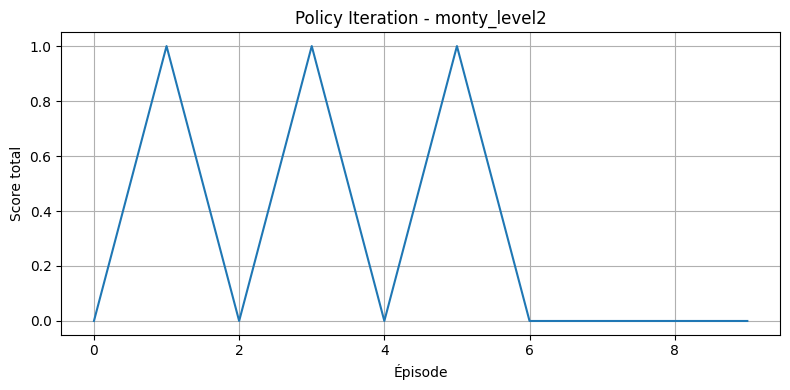

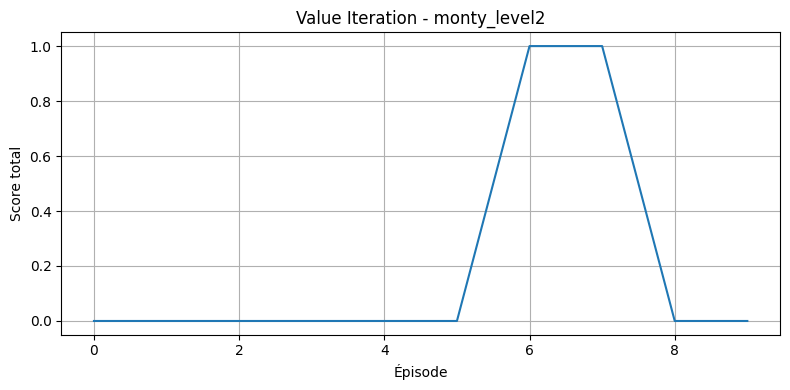

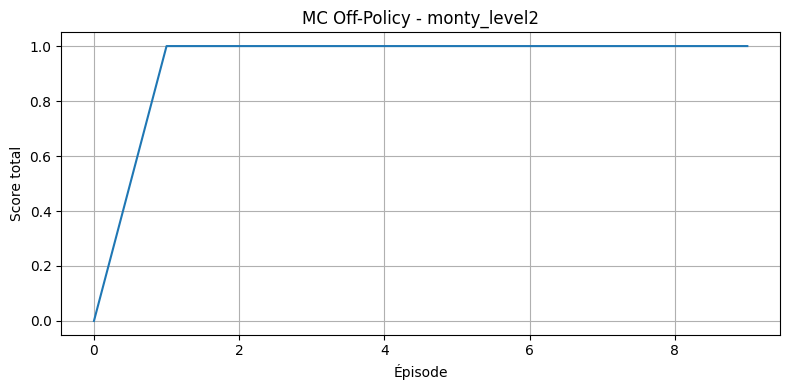

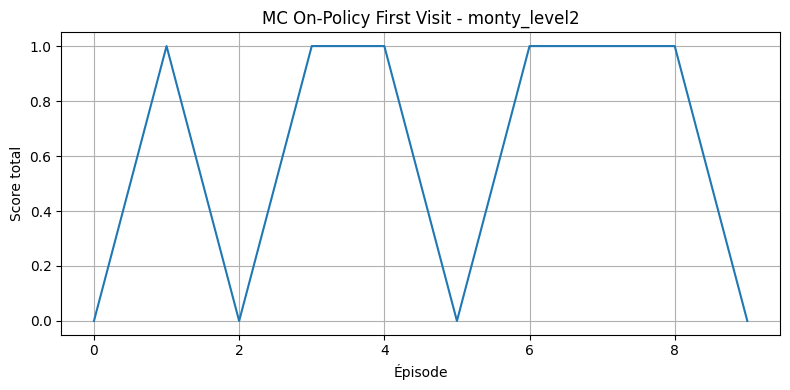

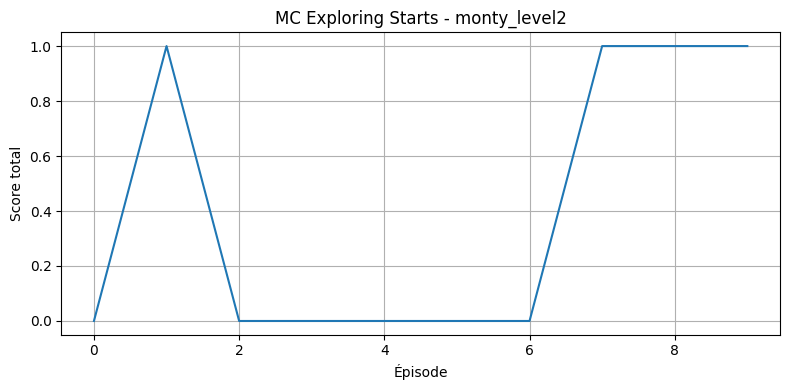

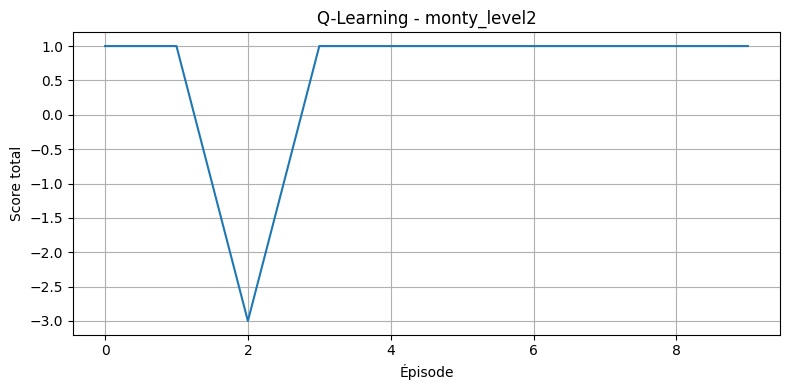

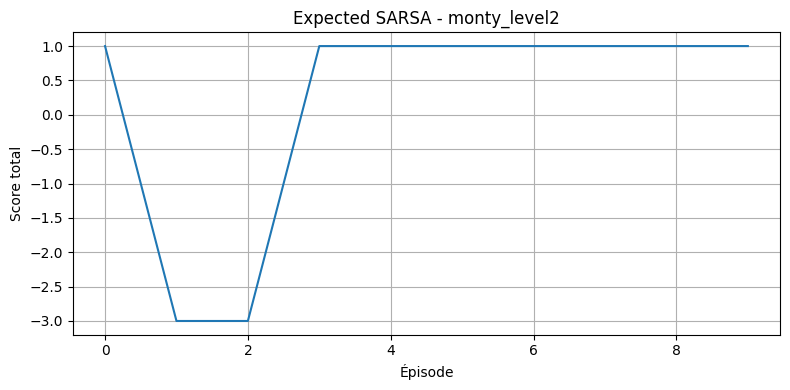

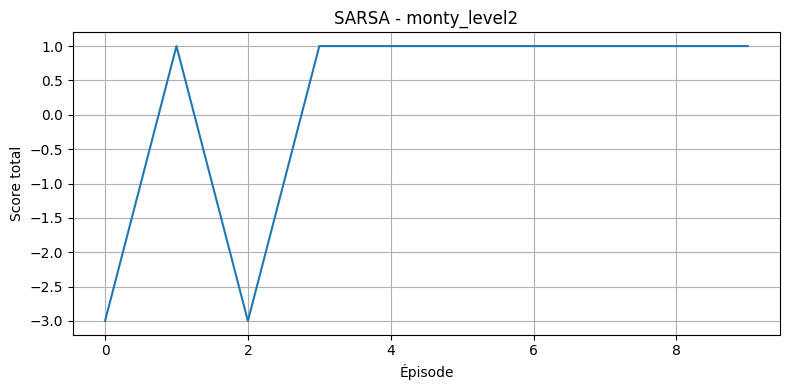

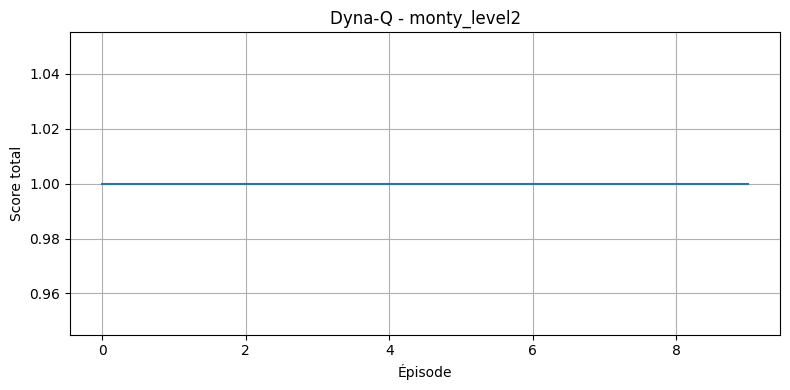

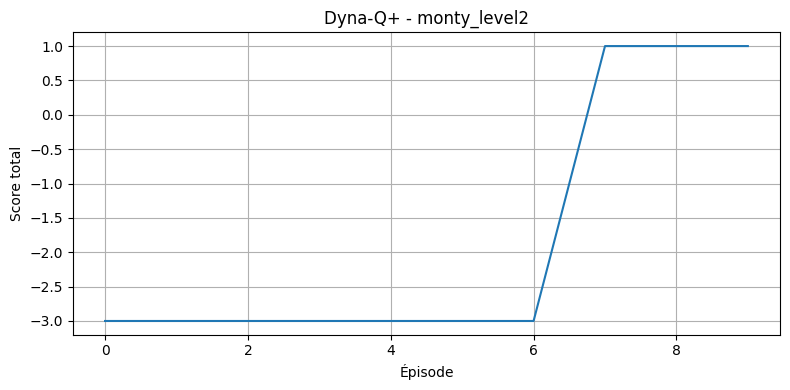

In [ ]:

plot_scores(scores_pi, title=f"Policy Iteration - {env_name}")
plot_scores(scores_vi, title=f"Value Iteration - {env_name}")
plot_scores(scores_mc_off_policy, title=f"MC Off-Policy - {env_name}")
plot_scores(scores_mc_on_policy, title=f"MC On-Policy First Visit - {env_name}")
plot_scores(scores_mc_exploring_starts, title=f"MC Exploring Starts - {env_name}")
plot_scores(scores_q, title=f"Q-Learning - {env_name}")
plot_scores(scores_esarsa, title=f"Expected SARSA - {env_name}")
plot_scores(scores_sarsa, title=f"SARSA - {env_name}")
plot_scores(scores_dq, title=f"Dyna-Q - {env_name}")
plot_scores(scores_dqplus, title=f"Dyna-Q+ - {env_name}")

#### Interpretation Monty Hall "Paradox" - Niveau 2 :
 Le niveau 2 du probl√®me de Monty Hall est plus complexe que le premier car il introduit un plus grand nombre de portes et n√©cessite plusieurs √©tapes d‚Äô√©limination successives avant la d√©cision finale. Cela rend la politique optimale moins imm√©diate √† identifier. On constate que les algorithmes de Dynamic Programming comme Policy Iteration ou Value Iteration atteignent des r√©sultats corrects mais oscillent davantage en raison de la structure s√©quentielle et plus profonde de l‚Äôenvironnement. Les m√©thodes Monte Carlo sont bien adapt√©es ici : elles permettent d‚Äôexplorer les diff√©rentes s√©quences d‚Äôactions et d‚Äôajuster la politique en fonction de l‚Äôexp√©rience, ce qui se traduit par une convergence assez rapide pour Off-Policy et plus oscillante pour On-Policy First Visit. Les algorithmes TD Learning (Q-Learning, Sarsa, Expected Sarsa) finissent par converger apr√®s quelques √©pisodes d‚Äôexploration, malgr√© des d√©buts parfois erratiques. Cela est d√ª √† la n√©cessit√© de comprendre que les choix initiaux influencent les √©tapes finales. Enfin, les m√©thodes de planning telles que Dyna-Q ou Dyna-Q+ n‚Äôapportent que peu d‚Äôavantages dans cet environnement simple mais s√©quentiel. Elles fonctionnent, mais n‚Äôapportent pas d‚Äôefficacit√© particuli√®re par rapport aux autres approches

# Avec l'environment RockPaperScissorsMDP :

In [17]:
env_name = "rps"
env_class = RockPaperScissorsMDP 


# Policy Iteration
policy_pi, V_pi, _ = run_experiment(
    env_class, policy_iteration, "policy_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=10)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)

# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(env_class, value_iteration, "value_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=10)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

# Pour Monte Carlo Off-Policy Control 
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99
)

# Pour Monte Carlo Off-Policy Control
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
    env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
   nb_episodes=10, gamma=0.99)


# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10, gamma=0.99, epsilon=0.01)

policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99)

Policy Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]


Politique et valeurs sauvegard√©es pour rps avec policy_iteration


√âvaluation de la politique: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 7162.40it/s]


Policy Iteration summary: {'mean': np.float64(-0.1), 'std': np.float64(0.8306623862918076), 'min': np.float64(-1.0), 'max': np.float64(1.0)}
Politique et valeurs sauvegard√©es pour rps avec value_iteration


√âvaluation de la politique: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 16371.21it/s]


Value Iteration summary: {'mean': np.float64(0.1), 'std': np.float64(0.8306623862918076), 'min': np.float64(-1.0), 'max': np.float64(1.0)}


MC Exploring Starts: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 7089.76it/s]


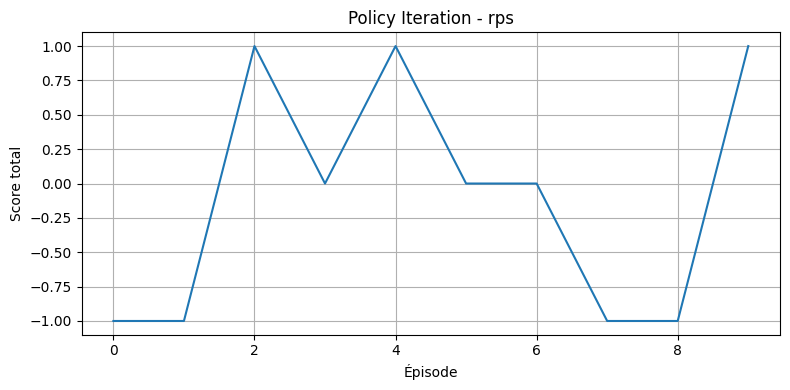

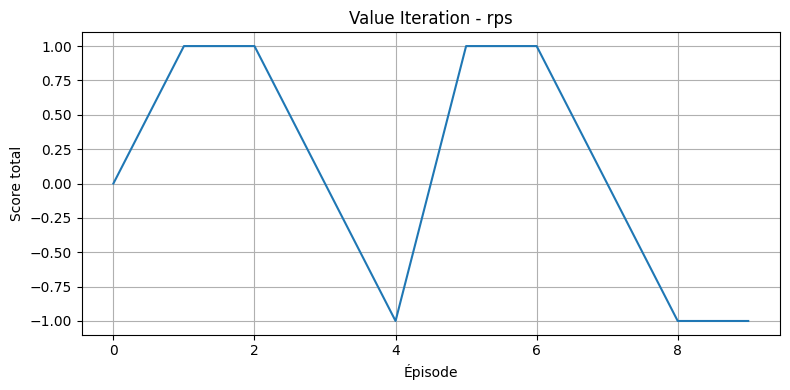

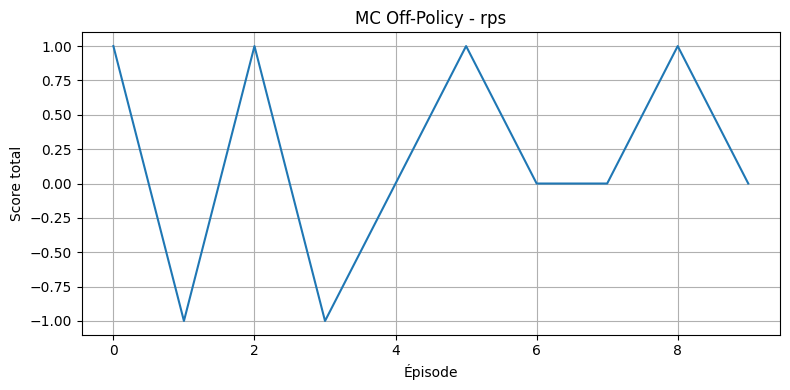

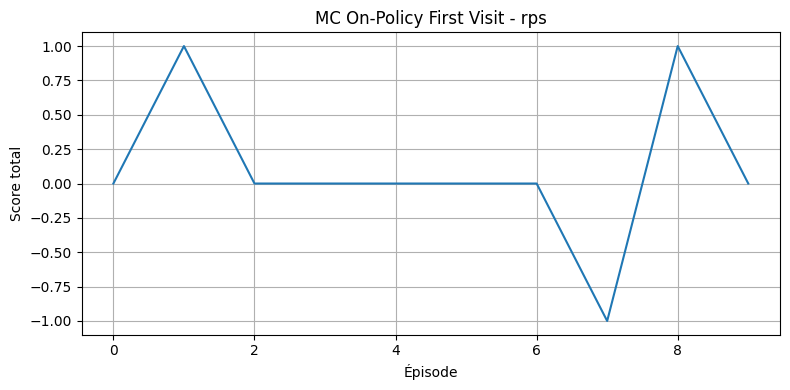

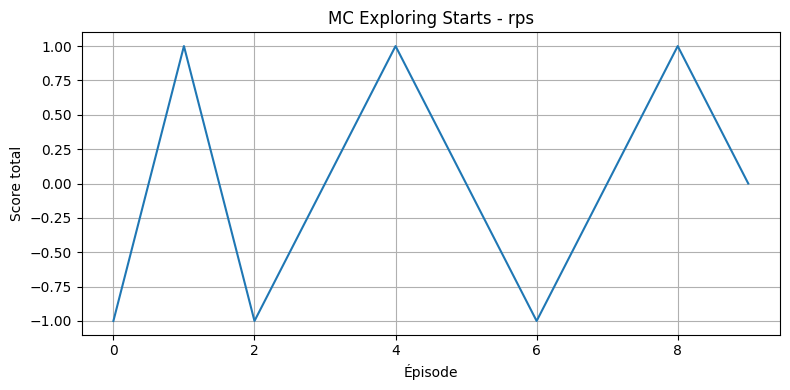

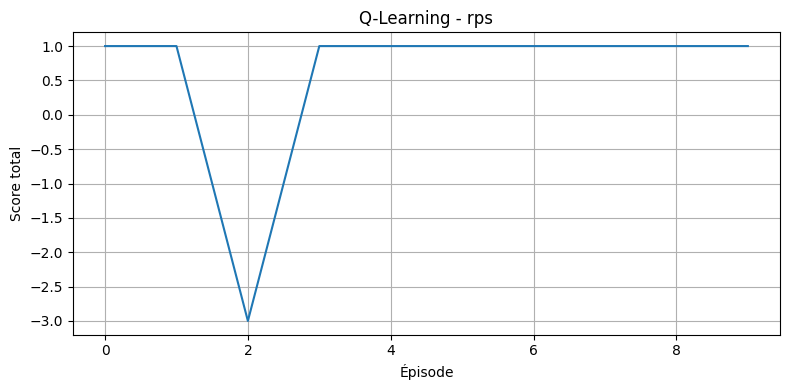

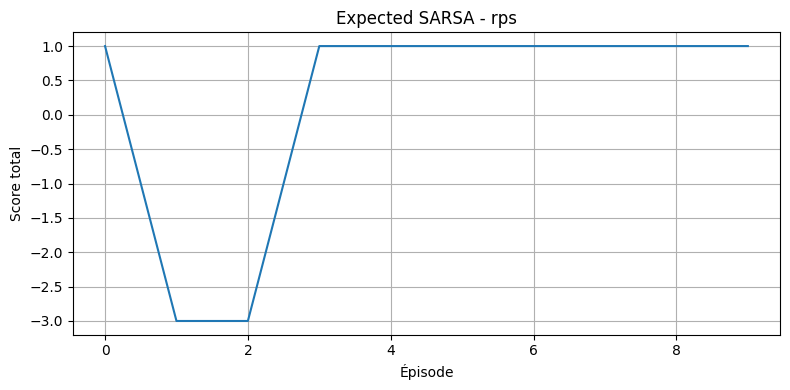

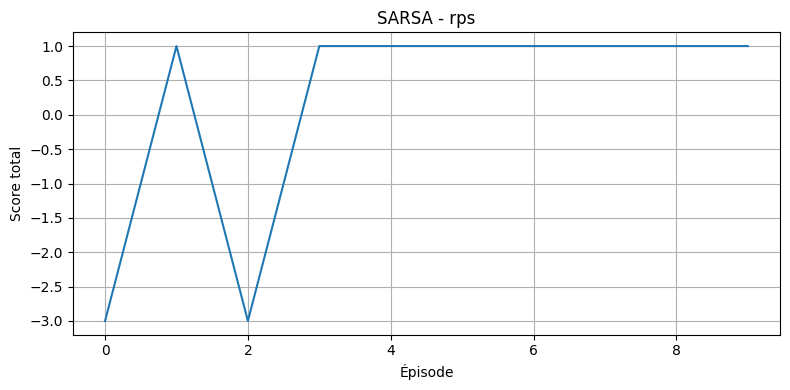

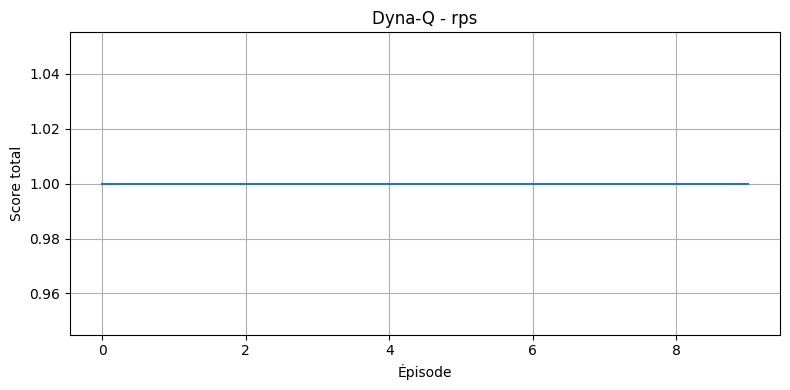

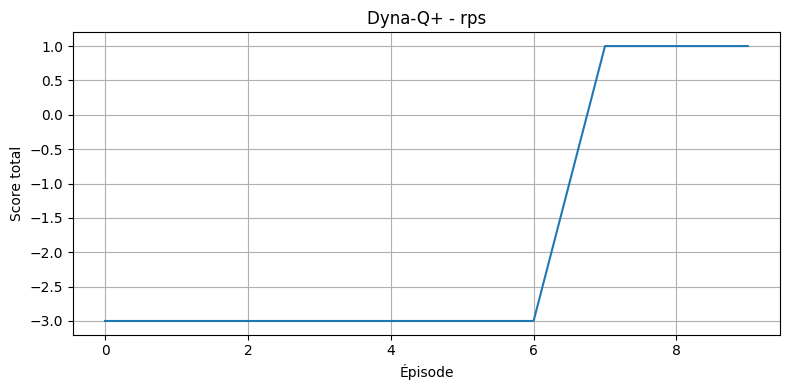

In [18]:

plot_scores(scores_pi, title=f"Policy Iteration - {env_name}")
plot_scores(scores_vi, title=f"Value Iteration - {env_name}")
plot_scores(scores_mc_off_policy, title=f"MC Off-Policy - {env_name}")
plot_scores(scores_mc_on_policy, title=f"MC On-Policy First Visit - {env_name}")
plot_scores(scores_mc_exploring_starts, title=f"MC Exploring Starts - {env_name}")
plot_scores(scores_q, title=f"Q-Learning - {env_name}")
plot_scores(scores_esarsa, title=f"Expected SARSA - {env_name}")
plot_scores(scores_sarsa, title=f"SARSA - {env_name}")
plot_scores(scores_dq, title=f"Dyna-Q - {env_name}")
plot_scores(scores_dqplus, title=f"Dyna-Q+ - {env_name}")

# avec l'env rps_two_rounds 

In [19]:
env_name = "rps_two_rounds"
env_class = TwoRoundRPS 


# Policy Iteration
policy_pi, V_pi, _ = run_experiment(
    env_class, policy_iteration, "policy_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=10)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)

# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(env_class, value_iteration, "value_iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=10)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

# Pour Monte Carlo Off-Policy Control 
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99
)

# Pour Monte Carlo Off-Policy Control
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
    env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
   nb_episodes=10, gamma=0.99)


# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10, gamma=0.99, epsilon=0.01)

policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10, gamma=0.99)

Policy Iteration:   0%|          | 2/1000 [00:02<17:54,  1.08s/it]


Politique et valeurs sauvegard√©es pour rps_two_rounds avec policy_iteration


√âvaluation de la politique: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 21399.51it/s]


Policy Iteration summary: {'mean': np.float64(0.6), 'std': np.float64(0.66332495807108), 'min': np.int64(0), 'max': np.int64(2)}
Politique et valeurs sauvegard√©es pour rps_two_rounds avec value_iteration


√âvaluation de la politique: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 42238.71it/s]


Value Iteration summary: {'mean': np.float64(1.1), 'std': np.float64(0.7), 'min': np.int64(0), 'max': np.int64(2)}


MC Exploring Starts: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:00<00:00, 3357.32it/s]


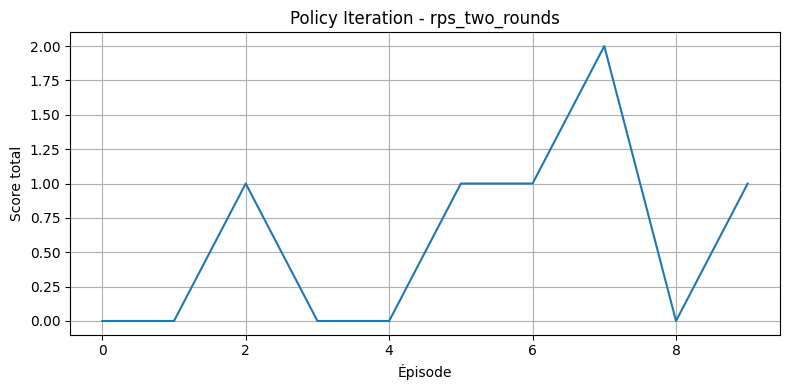

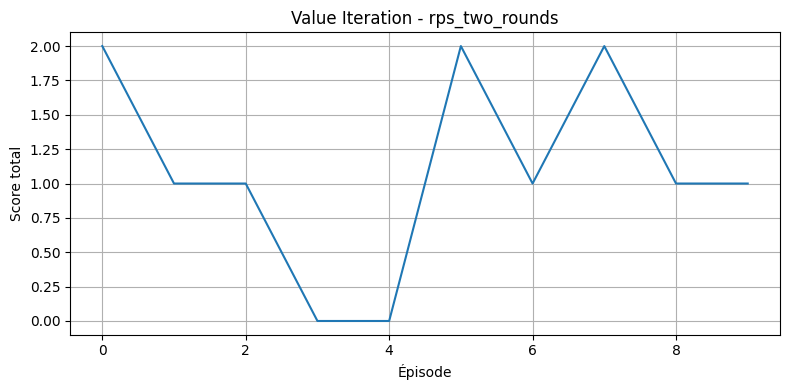

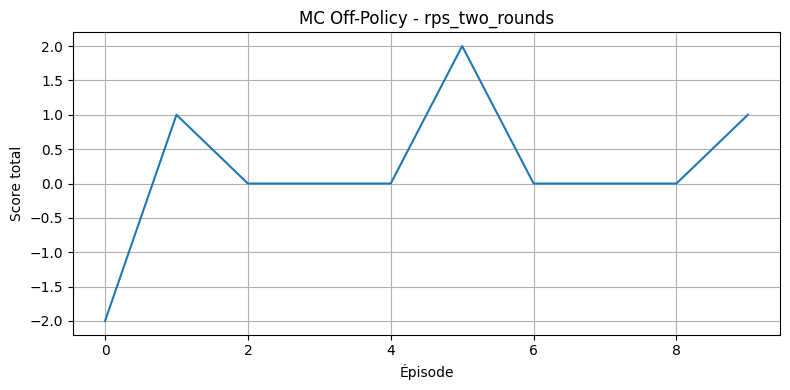

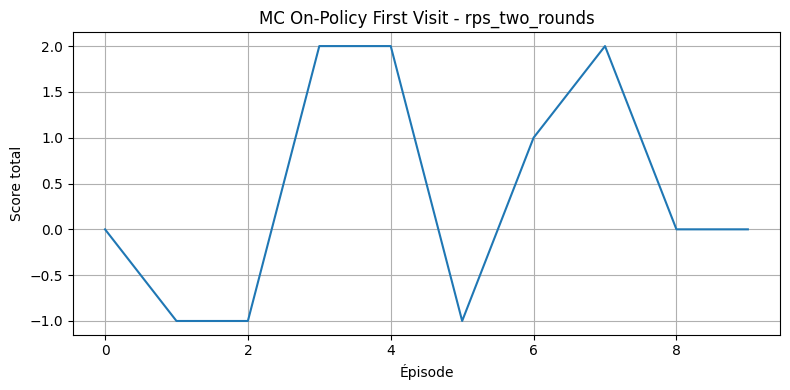

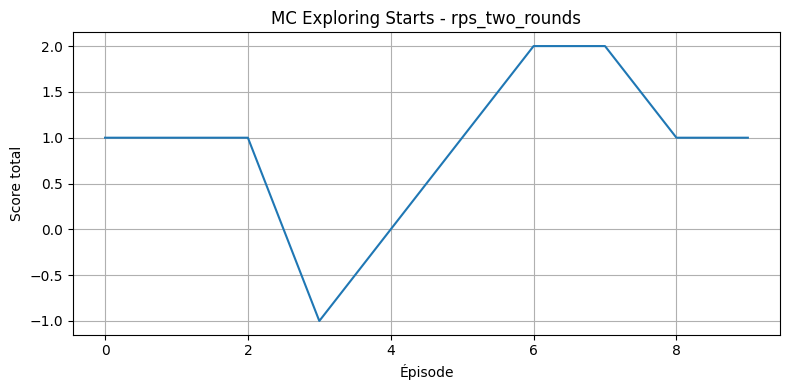

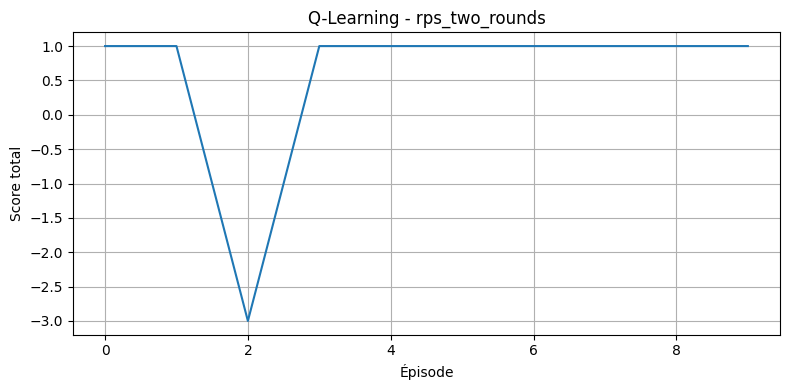

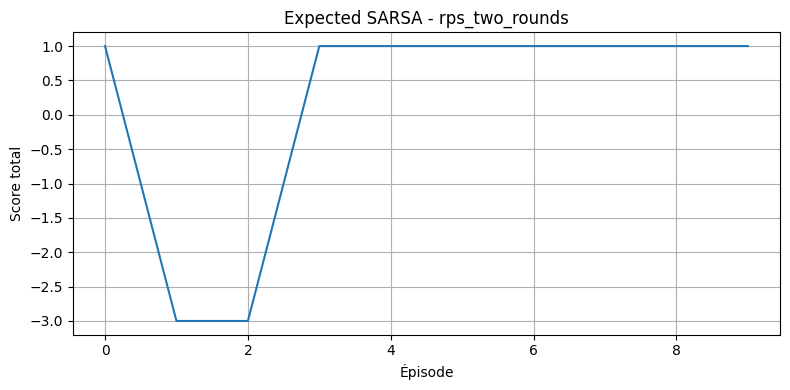

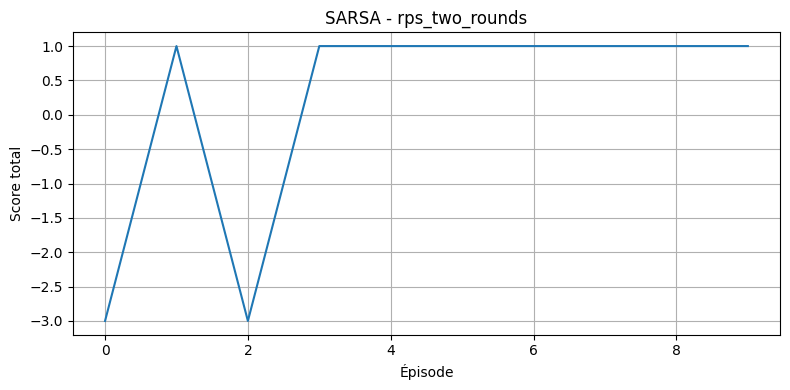

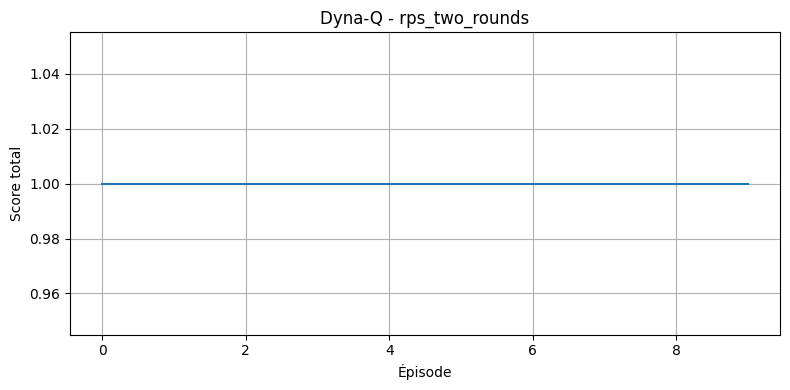

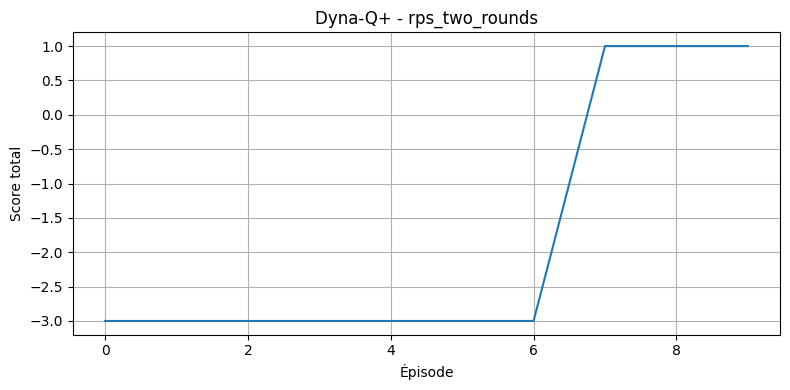

In [20]:

plot_scores(scores_pi, title=f"Policy Iteration - {env_name}")
plot_scores(scores_vi, title=f"Value Iteration - {env_name}")
plot_scores(scores_mc_off_policy, title=f"MC Off-Policy - {env_name}")
plot_scores(scores_mc_on_policy, title=f"MC On-Policy First Visit - {env_name}")
plot_scores(scores_mc_exploring_starts, title=f"MC Exploring Starts - {env_name}")
plot_scores(scores_q, title=f"Q-Learning - {env_name}")
plot_scores(scores_esarsa, title=f"Expected SARSA - {env_name}")
plot_scores(scores_sarsa, title=f"SARSA - {env_name}")
plot_scores(scores_dq, title=f"Dyna-Q - {env_name}")
plot_scores(scores_dqplus, title=f"Dyna-Q+ - {env_name}")

#### Interpretation :two round rock paper scissors :
 L‚Äôenvironnement Two Round Rock Paper Scissors est tr√®s particulier car il repose √† la fois sur un comportement al√©atoire de l‚Äôadversaire lors du premier tour et sur un comportement totalement d√©terministe au second (copie du choix de l‚Äôagent). Cela g√©n√®re une dynamique o√π l'agent doit anticiper non seulement le r√©sultat du premier tour, mais surtout exploiter l‚Äôinformation du second pour optimiser son score global. Les m√©thodes de Dynamic Programming (Policy Iteration, Value Iteration) ne sont pas bien adapt√©es √† cet environnement, car le faible nombre d‚Äô√©tats et l‚Äôal√©atoire du premier tour rendent difficile la mod√©lisation d‚Äôune politique fixe r√©ellement optimale. Cela se refl√®te par des r√©sultats tr√®s irr√©guliers au fil des √©pisodes. Les m√©thodes Monte Carlo, qu‚Äôelles soient On-Policy ou Off-Policy, parviennent √† mieux exploiter la structure du probl√®me gr√¢ce √† l‚Äô√©chantillonnage des √©pisodes complets, m√™me si leurs performances restent variables selon les s√©quences de jeux rencontr√©es. On observe qu'elles peuvent rapidement atteindre un score √©lev√©, mais oscillent encore entre gains et pertes. Du c√¥t√© des m√©thodes TD Learning (Q-Learning, Sarsa, Expected Sarsa), on constate qu‚Äôelles finissent par stabiliser des politiques correctes malgr√© des d√©buts chaotiques. Elles b√©n√©ficient de la simplicit√© de l‚Äôenvironnement pour converger, mais les fluctuations des r√©sultats montrent que quelques √©pisodes d‚Äôexploration sont n√©cessaires pour int√©grer pleinement la m√©canique sp√©cifique de l‚Äôadversaire. Enfin, Dyna-Q et Dyna-Q+ n‚Äôapportent pas d‚Äôam√©lioration notable sur cet environnement. La taille r√©duite de l‚Äôespace d‚Äô√©tats et d‚Äôactions, ainsi que l‚Äôabsence de transitions complexes, limitent fortement l‚Äôint√©r√™t d‚Äôune mod√©lisation suppl√©mentaire pour planifier